## Preliminaries

In [2]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 727 µs (started: 2023-01-04 20:40:09 +08:00)


In [3]:
# check python version
# lensinggw package requires python 3.8+

! python --version

Python 3.9.13
time: 142 ms (started: 2023-01-04 20:40:09 +08:00)


In [4]:
# cd to lenstronomy location
%cd /Users/genebelinario/Documents/dnc_research/thesis/notebooks
!ls

/Users/genebelinario/Documents/dnc_research/thesis/notebooks
LOSC_Event_tutorial-master lenstronomy_solver.ipynb
gw_microlensing.ipynb      near_source.ipynb
gwlensing_10e7.ipynb       plot_10e610e7.ipynb
lensed_gw.ipynb            plots.ipynb
lensed_unlensed_gw.ipynb   source_0.png
lensinggw                  source_1.png
lensinggw_setup.ipynb      source_2.png
lenstronomy                try.ipynb
time: 135 ms (started: 2023-01-04 20:40:09 +08:00)


In [5]:
# import libraries and packages

import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import configparser
import pandas as pd

time: 822 ms (started: 2023-01-04 20:40:09 +08:00)


In [6]:
# import specific packages
from lensinggw.utils.utils import param_processing
from lensinggw.solver.images import microimages
from lensinggw.utils.utils import TimeDelay, magnifications, getMinMaxSaddle
from lensinggw.amplification_factor.amplification_factor import geometricalOpticsMagnification
from lensinggw.postprocess.postprocess import plot_images

time: 899 ms (started: 2023-01-04 20:40:11 +08:00)


## **Unlensed Gravitational Wave Signal**

In [7]:
# chirp mass = 60, q = 1
# m1 = 68.921901
# m2 = 68.921901
# nonspinning

# This script illustrates how to use lensingGW's unlensed waveform routines

from lensinggw.waveform.waveform import gw_signal

# read the waveform parameters
config_file = '/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/ini_files/waveform_config.ini'

# instantiate the waveform model
waveform_model = gw_signal(config_file)

# compute the unlensed waveform polarizations, strains in the requested detectors and their frequencies
freqs, hp_tilde, hc_tilde, strain_dict = waveform_model.unlensed_gw()

# and their signal-to-noise-ratios
SNR_dict = waveform_model.unlensed_snr()

# access an unlensed strain
sH1 = strain_dict['H1']


---- Will simulate a signal with the following parameters ----

m1          --> 45
m2          --> 36
spin1x      --> 0.0
spin1y      --> 0.0
spin1z      --> 0.0
spin2x      --> 0.0
spin2y      --> 0.0
spin2z      --> 0.0
distance    --> 15521.788104196934
ra          --> 0
dec         --> 4.904407255147181e-09
psi         --> 0.0
inclination --> 2.6
phi0        --> 0.0
lambda1     --> 0.0
lambda2     --> 0.0


---- Will use the following setup ----

flow          --> 20.0
fhigh         --> 1024
fref          --> 20.0
df            --> 0.125
sampling-rate --> 2048
approximant   --> IMRPhenomPv2
amp_order     --> 0
phase_order   --> -1
starttime     --> -7.0
trigtime      --> 0.0


---- Will simulate the signal in the following detectors ----

H1     --> True
H1-psd --> /Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat


Unlensed SNR in H1 = 1.80
Network SNR of the unlensed simulation 1.804045

time: 40

## **Case 1**

For an SIE with mass $M_G = 10^{6}M_{\odot}$. 

In [8]:
## Determine macroimages of the SIE.

# coordinates in scaled units x (radians) / thetaE
# a.k.a source position in scaled units
y0, y1 = 0, 0.5

# redshifts
zS = 2.0
zL = 0.5

# mass of lens in solar mass units
mSIE_10e6 = 10**6

# Einstein angle in radians
thetaE_SIE_10e6 = param_processing(zL, zS, mSIE_10e6)

# source position in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# lens model
lens_model_list     = ['SIE']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_lens_list    = [kwargs_SIE]

# compute for macroimage positions
solver_kwargs = {'SearchWindowMacro' : 4*thetaE_SIE_10e6,
                         'OnlyMacro' : True,
                        'MacroIndex' : [0],
                      'Optimization' : True,
                       'PixelsMacro' : 10**3} 

MacroImg_ra_10e6, MacroImg_dec_10e6, pixel_width_10e6  = microimages(source_pos_x    = beta0,
                                                                     source_pos_y    = beta1,
                                                                     lens_model_list = lens_model_list,
                                                                     kwargs_lens     = kwargs_lens_list,
                                                                     **solver_kwargs)

# time delays
tds_10e6 = TimeDelay(MacroImg_ra_10e6, MacroImg_dec_10e6, beta0, beta1, zL, zS,
                     lens_model_list, kwargs_lens_list) 

# magnifications
mus_10e6 = magnifications(MacroImg_ra_10e6, MacroImg_dec_10e6, lens_model_list, kwargs_lens_list)

# Morse indices
ns_10e6  = getMinMaxSaddle(MacroImg_ra_10e6, MacroImg_dec_10e6, lens_model_list, kwargs_lens_list) 
                
print('Time delays (seconds): ', tds_10e6)
print('magnifications: ',  mus_10e6)
print('Morse indices: ',ns_10e6)

dummy_frequencies = np.linspace(0,10,11)
F = geometricalOpticsMagnification(dummy_frequencies,
                                   MacroImg_ra_10e6,MacroImg_dec_10e6,
                                   beta0,beta1,
                                   zL,zS,
                                   lens_model_list,
                                   kwargs_lens_list)
print('Geometrical optics amplification factor:', F)


---- Will perform only the macromodel analysis ----

---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro                       --> True
Scaled                          --> False
SearchWindowMacro               --> 3.923525804117745e-08
PixelsMacro                     --> 1000
OverlapDistMacro                --> 1e-15
NearSource                      --> False
Optimization                    --> True
Verbose                         --> False
OptimizationWindowMacro         --> 2
OptimizationPixelsMacro         --> 30
MinDistMacro                    --> None
ImprovementMacro                --> None
OptimizationPrecisionLimitMacro --> 1e-20




MACROIMAGES

ra: [ 7.64953018e-21 -4.96308526e-24 -4.96308526e-24]
dec: [ 1.43606231e-08 -4.39823477e-09 -1.56357004e-10]

Time delays (seconds):  [ 0.         28.34730176 30.476578  ]
magnifications:  [ 3.80591423e+00 -7.70297588e-01  1.19870864e-03]
Morse indices:  [0, 0.5, 1]
Geometrical o

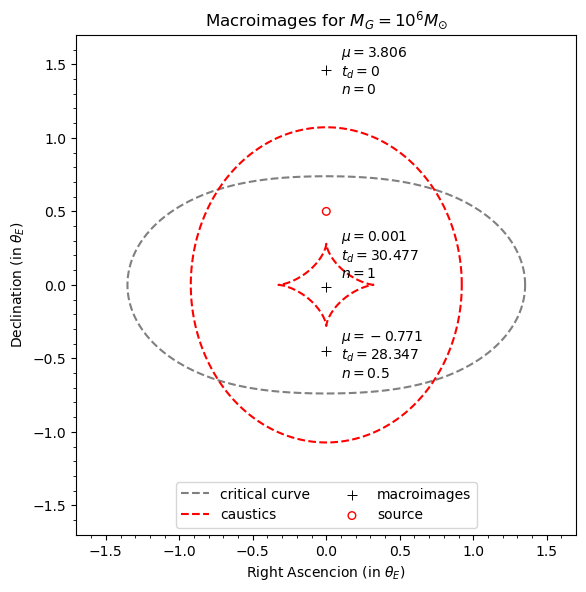

time: 514 ms (started: 2023-01-04 20:40:21 +08:00)


In [9]:
## parametrized curves

epsilon = 0.15
t = np.arange(0, 2*np.pi, 0.001)

# inner caustics
beta_1_in = (2*epsilon/np.sqrt(1-epsilon))*((np.cos(t))**3)
beta_2_in = (2*epsilon/np.sqrt(1+epsilon))*((np.sin(t))**3)

# outer caustics
beta_1_out = ((1-epsilon)/np.sqrt(1-epsilon))*np.cos(t)
beta_2_out = ((1+epsilon)/np.sqrt(1+epsilon))*np.sin(t)

# critical curve
rho = 1 + epsilon*np.cos(2*t)
theta_1 = (1-epsilon)**(-1)*rho*np.cos(t)
theta_2 = (1+epsilon)**(-1)*rho*np.sin(t)

# Sky plot of the macroimages
nr_10e6, nc_10e6 = 1, 1

fig_10e6, axs_10e6 = plt.subplots(nrows=nr_10e6, ncols=nc_10e6, sharey=True, sharex=True, figsize=(6,6))

axs_10e6.plot(theta_1, theta_2, color='grey', linewidth=1.5, label='critical curve', linestyle='--')
axs_10e6.plot(beta_1_in, beta_2_in, color='red', linewidth=1.5, label='caustics', linestyle='--')
axs_10e6.plot(beta_1_out, beta_2_out, color='red', linewidth=1.5, linestyle='--')

axs_10e6.scatter(MacroImg_ra_10e6/thetaE_SIE_10e6, MacroImg_dec_10e6/thetaE_SIE_10e6, marker='+', label='macroimages', 
                 s=60, linewidth=0.7, color='black')
axs_10e6.scatter(y0, y1, color='red', s=30, label='source', facecolor='none')

axs_10e6.set_title(r'Macroimages for $M_G = 10^{6}M_{\odot}$')
axs_10e6.set(xlabel=r'Right Ascencion (in $\theta_E$)', ylabel=r'Declination (in $\theta_E$)')
axs_10e6.label_outer()
axs_10e6.minorticks_on()
axs_10e6.set_xlim([-1.7,1.7])
axs_10e6.set_ylim([-1.7,1.7])
axs_10e6.set_aspect('equal', adjustable='box')
axs_10e6.legend(ncol=2, loc='lower center')

axs_10e6.text(0.1, 1.3, r'$\mu = 3.806$' + '\n' + r'$t_d = 0$' + '\n' + r'$n=0$')
axs_10e6.text(0.1, 0.05, r'$\mu = 0.001$' + '\n' + r'$t_d = 30.477$' + '\n' + r'$n=1$')
axs_10e6.text(0.1, -0.63, r'$\mu = -0.771$' + '\n' + r'$t_d = 28.347$' + '\n' + r'$n=0.5$')

plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/MacroImg_10e6', dpi=300)
plt.show()

In [10]:
# PML at most magnified image in the positive parity side of SIE

# Macroimages in the positive parity side
# RA, Dec = 7.64953018e-21, 1.43606231e-08 ; n = 0 ; mu = 3.80591423e+00 --> most magnified
# RA, Dec = -4.96308526e-24, -1.56357004e-10 ; n = 1 ; mu = 1.19870864e-03


# coordinates in scaled units x (radians) / thetaE
# a.k.a source position in scaled units
y0, y1 = 0, 0.5

# redshifts
zS = 2.0
zL = 0.5

# mass of lens in solar mass units
mSIE_10e6 = 10**6
mPML = 100
m_total = mSIE_10e6 + mPML

# Einstein angle in radians
thetaE_SIE_10e6 = param_processing(zL, zS, mSIE_10e6)
thetaE_PML = param_processing(zL, zS, mPML)
thetaE = param_processing(zL, zS, m_total)

# source position in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# lens model
lens_model_list     = ['SIE', 'POINT_MASS']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_PML          = {'center_x':MacroImg_ra_10e6[0], 'center_y':MacroImg_dec_10e6[0], 'theta_E':thetaE_PML}
kwargs_lens_list    = [kwargs_SIE, kwargs_PML]

# compute for macroimage positions
solver_kwargs = {'SearchWindowMacro' : 4*thetaE_SIE_10e6,
                      'SearchWindow' : 4*thetaE_SIE_10e6,
                  'MacroIndex'       : [0],
                      'Optimization' : True,
                       'PixelsMacro' : 10**3} 

Img_ra_10e6_PML, Img_dec_10e6_PML, MacroImg_ra_10e6, MacroImg_dec_10e6, pixel_width_10e6  = microimages(source_pos_x= beta0,
                                                   source_pos_y    = beta1,
                                                   lens_model_list = lens_model_list,
                                                   kwargs_lens     = kwargs_lens_list,
                                                    **solver_kwargs)

# time delays
tds_10e6_PML = TimeDelay(Img_ra_10e6_PML, Img_dec_10e6_PML, beta0, beta1, zL, zS,
                     lens_model_list, kwargs_lens_list) 

# magnifications
mus_10e6_PML = magnifications(Img_ra_10e6_PML, Img_dec_10e6_PML, lens_model_list, kwargs_lens_list)

# Morse indices
ns_10e6_PML  = getMinMaxSaddle(Img_ra_10e6_PML, Img_dec_10e6_PML, lens_model_list, kwargs_lens_list) 
                
print('Time delays (seconds): ', tds_10e6_PML)
print('magnifications: ',  mus_10e6_PML)
print('Morse indices: ',ns_10e6_PML)

dummy_frequencies = np.linspace(0,10,11)
F = geometricalOpticsMagnification(dummy_frequencies,
                                   Img_ra_10e6_PML, Img_dec_10e6_PML,
                                   beta0,beta1,
                                   zL,zS,
                                   lens_model_list,
                                   kwargs_lens_list)
print('Geometrical optics amplification factor:', F)



---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro                       --> False
Scaled                          --> False
SearchWindowMacro               --> 3.923525804117745e-08
PixelsMacro                     --> 1000
OverlapDistMacro                --> 1e-15
NearSource                      --> False
Optimization                    --> True
Verbose                         --> False
OptimizationWindowMacro         --> 2
OptimizationPixelsMacro         --> 30
MinDistMacro                    --> None
ImprovementMacro                --> None
OptimizationPrecisionLimitMacro --> 1e-20




MACROIMAGES

ra: [ 7.64953018e-21 -4.96308526e-24 -4.96308526e-24]
dec: [ 1.43606231e-08 -4.39823477e-09 -1.56357004e-10]


---- Solver settings ----

The complete model analysis will be performed with the following settings:

Scaled                          --> False
OnlyMacro                       --> False
MacroIndex                      --

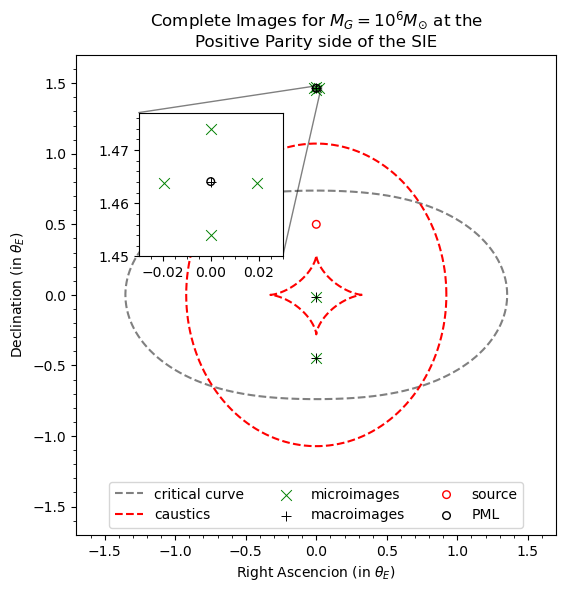

time: 430 ms (started: 2023-01-04 20:40:36 +08:00)


In [11]:
# Sky plot of the complete model
# PML at the most magnified macroimage on the positive side of the SIE

nr_10e6_PML, nc_10e6_PML = 1, 1

fig_10e6_PML, axs_10e6_PML = plt.subplots(nrows=nr_10e6_PML, ncols=nc_10e6_PML, sharey=True, sharex=True, figsize=(6,6))

axs_10e6_PML.plot(theta_1, theta_2, color='grey', linewidth=1.5, label='critical curve', linestyle='--')
axs_10e6_PML.plot(beta_1_in, beta_2_in, color='red', linewidth=1.5, label='caustics', linestyle='--')
axs_10e6_PML.plot(beta_1_out, beta_2_out, color='red', linewidth=1.5, linestyle='--')

axs_10e6_PML.scatter(Img_ra_10e6_PML/thetaE, Img_dec_10e6_PML/thetaE, marker='x', label='microimages', 
                     s=60, linewidth=0.7, color='green')
axs_10e6_PML.scatter(MacroImg_ra_10e6/thetaE, MacroImg_dec_10e6/thetaE, marker='+', label='macroimages', 
                     s=60, linewidth=0.7, color='black')
axs_10e6_PML.scatter(y0, y1, color='red', s=30, label='source', facecolor='none')
axs_10e6_PML.scatter(MacroImg_ra_10e6[0]/thetaE_SIE_10e6, MacroImg_dec_10e6[0]/thetaE_SIE_10e6, 
                     label='PML', color='black', s=30, facecolor='none')

# inset axes....
axins_10e6_PML = axs_10e6_PML.inset_axes([0.13, 0.58, 0.3, 0.3])
axins_10e6_PML.scatter(Img_ra_10e6_PML/thetaE, Img_dec_10e6_PML/thetaE, marker='x', label='microimages', 
                 s=60, linewidth=0.7, color='green')
axins_10e6_PML.scatter(MacroImg_ra_10e6[0]/thetaE_SIE_10e6, MacroImg_dec_10e6[0]/thetaE_SIE_10e6, 
                     label='PML', color='black', s=30, facecolor='none')
axins_10e6_PML.scatter(MacroImg_ra_10e6/thetaE, MacroImg_dec_10e6/thetaE, marker='+', label='macroimages', 
                     s=60, linewidth=0.7, color='black')

# sub region of the original image
xx1, xx2, yy1, yy2 = -0.03, 0.03, 1.45, 1.477
axins_10e6_PML.set_xlim(xx1, xx2)
axins_10e6_PML.set_ylim(yy1, yy2)
#axins_10e6_PML.set_xticklabels([])
#axins_10e6_PML.set_yticklabels([])
axins_10e6_PML.minorticks_on()
axs_10e6_PML.indicate_inset_zoom(axins_10e6_PML, edgecolor="black")
axs_10e6_PML.minorticks_on()


axs_10e6_PML.set_title(r'Complete Images for $M_G = 10^{6}M_{\odot}$ at the' + '\n' + r'Positive Parity side of the SIE')
axs_10e6_PML.set(xlabel=r'Right Ascencion (in $\theta_E$)', ylabel=r'Declination (in $\theta_E$)')
axs_10e6_PML.label_outer()
axs_10e6_PML.minorticks_on()
axs_10e6_PML.set_xlim([-1.7,1.7])
axs_10e6_PML.set_ylim([-1.7,1.7])
axs_10e6_PML.set_aspect('equal', adjustable='box')
axs_10e6_PML.legend(ncol=3, loc='lower center')

plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/CompleteImg_10e6_PML_PosParity', dpi=300)
plt.show()

In [12]:
# PML at most magnified image in the negative parity side of SIE

# Macroimages in the negative parity side
# RA, Dec = -4.96308526e-24, -4.39823477e-09 ; n = 0.5 ; mu = -7.70297588e-01 --> most magnified


# coordinates in scaled units x (radians) / thetaE
# a.k.a source position in scaled units
y0, y1 = 0, 0.5

# redshifts
zS = 2.0
zL = 0.5

# mass of lens in solar mass units
mSIE_10e6 = 10**6
mPML = 100
m_total = mSIE_10e6 + mPML

# Einstein angle in radians
thetaE_SIE_10e6 = param_processing(zL, zS, mSIE_10e6)
thetaE_PML = param_processing(zL, zS, mPML)
thetaE = param_processing(zL, zS, m_total)

# source position in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# lens model
lens_model_list     = ['SIE', 'POINT_MASS']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_PML          = {'center_x':MacroImg_ra_10e6[1], 'center_y':MacroImg_dec_10e6[1], 'theta_E':thetaE_PML}
kwargs_lens_list    = [kwargs_SIE, kwargs_PML]

# compute for macroimage positions
solver_kwargs = {'SearchWindowMacro' : 4*thetaE_SIE_10e6,
                      'SearchWindow' : 4*thetaE_SIE_10e6,
                 'MacroIndex'       : [0],
                      'Optimization' : True,
                       'PixelsMacro' : 10**3} 

Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg, MacroImg_ra_10e6, MacroImg_dec_10e6, pixel_width_10e6  = microimages(source_pos_x= beta0,
                                                   source_pos_y    = beta1,
                                                   lens_model_list = lens_model_list,
                                                   kwargs_lens     = kwargs_lens_list,
                                                    **solver_kwargs)

# time delays
tds_10e6_PML_neg = TimeDelay(Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg, beta0, beta1, zL, zS,
                     lens_model_list, kwargs_lens_list) 

# magnifications
mus_10e6_PML_neg = magnifications(Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg, lens_model_list, kwargs_lens_list)

# Morse indices
ns_10e6_PML_neg  = getMinMaxSaddle(Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg, lens_model_list, kwargs_lens_list) 
                
print('Time delays (seconds): ', tds_10e6_PML_neg)
print('magnifications: ',  mus_10e6_PML_neg)
print('Morse indices: ',ns_10e6_PML_neg)

dummy_frequencies = np.linspace(0,10,11)
F = geometricalOpticsMagnification(dummy_frequencies,
                                   Img_ra_10e6_PML_neg, Img_dec_10e6_PML_neg,
                                   beta0,beta1,
                                   zL,zS,
                                   lens_model_list,
                                   kwargs_lens_list)
print('Geometrical optics amplification factor:', F)



---- Solver settings ----

The macromodel analysis will be performed with the following settings:

OnlyMacro                       --> False
Scaled                          --> False
SearchWindowMacro               --> 3.923525804117745e-08
PixelsMacro                     --> 1000
OverlapDistMacro                --> 1e-15
NearSource                      --> False
Optimization                    --> True
Verbose                         --> False
OptimizationWindowMacro         --> 2
OptimizationPixelsMacro         --> 30
MinDistMacro                    --> None
ImprovementMacro                --> None
OptimizationPrecisionLimitMacro --> 1e-20




MACROIMAGES

ra: [ 7.64953018e-21 -4.96308526e-24 -4.96308526e-24]
dec: [ 1.43606231e-08 -4.39823477e-09 -1.56357004e-10]


---- Solver settings ----

The complete model analysis will be performed with the following settings:

Scaled                          --> False
OnlyMacro                       --> False
MacroIndex                      --

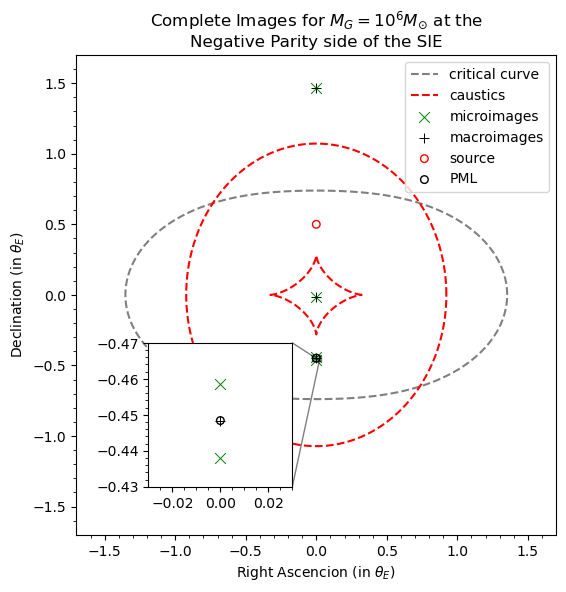

time: 498 ms (started: 2023-01-04 20:40:50 +08:00)


In [13]:
# Sky plot of the complete model
# PML at the most magnified macroimage on the positive side of the SIE

nr_10e6_PML_neg, nc_10e6_PML_neg = 1, 1

fig_10e6_PML_neg, axs_10e6_PML_neg = plt.subplots(nrows=nr_10e6_PML_neg, ncols=nc_10e6_PML_neg, sharey=True, sharex=True, figsize=(6,6))

axs_10e6_PML_neg.plot(theta_1, theta_2, color='grey', linewidth=1.5, label='critical curve', linestyle='--')
axs_10e6_PML_neg.plot(beta_1_in, beta_2_in, color='red', linewidth=1.5, label='caustics', linestyle='--')
axs_10e6_PML_neg.plot(beta_1_out, beta_2_out, color='red', linewidth=1.5, linestyle='--')

axs_10e6_PML_neg.scatter(Img_ra_10e6_PML_neg/thetaE, Img_dec_10e6_PML_neg/thetaE, marker='x', label='microimages', 
                     s=60, linewidth=0.7, color='green')
axs_10e6_PML_neg.scatter(MacroImg_ra_10e6/thetaE, MacroImg_dec_10e6/thetaE, marker='+', label='macroimages', 
                     s=60, linewidth=0.7, color='black')
axs_10e6_PML_neg.scatter(y0, y1, color='red', s=30, label='source', facecolor='none')
axs_10e6_PML_neg.scatter(MacroImg_ra_10e6[1]/thetaE_SIE_10e6, MacroImg_dec_10e6[1]/thetaE_SIE_10e6, 
                     label='PML', color='black', s=30, facecolor='none')

# inset axes....
axins_10e6_PML_neg = axs_10e6_PML_neg.inset_axes([0.15, 0.1, 0.3, 0.3])
axins_10e6_PML_neg.scatter(Img_ra_10e6_PML_neg/thetaE, Img_dec_10e6_PML_neg/thetaE, marker='x', label='microimages', 
                 s=60, linewidth=0.7, color='green')
axins_10e6_PML_neg.scatter(MacroImg_ra_10e6[1]/thetaE_SIE_10e6, MacroImg_dec_10e6[1]/thetaE_SIE_10e6, 
                     label='PML', color='black', s=30, facecolor='none')
axins_10e6_PML_neg.scatter(MacroImg_ra_10e6/thetaE, MacroImg_dec_10e6/thetaE, marker='+', label='macroimages', 
                     s=60, linewidth=0.7, color='black')

# sub region of the original image
xxx1, xxx2, yyy1, yyy2 = -0.03, 0.03, -0.43, -0.47
axins_10e6_PML_neg.set_xlim(xxx1, xxx2)
axins_10e6_PML_neg.set_ylim(yyy1, yyy2)
#axins_10e6_PML.set_xticklabels([])
#axins_10e6_PML.set_yticklabels([])
axins_10e6_PML_neg.minorticks_on()
axs_10e6_PML_neg.indicate_inset_zoom(axins_10e6_PML_neg, edgecolor="black")
axs_10e6_PML_neg.minorticks_on()


axs_10e6_PML_neg.set_title(r'Complete Images for $M_G = 10^{6}M_{\odot}$ at the' + '\n' + r'Negative Parity side of the SIE')
axs_10e6_PML_neg.set(xlabel=r'Right Ascencion (in $\theta_E$)', ylabel=r'Declination (in $\theta_E$)')
axs_10e6_PML_neg.label_outer()
axs_10e6_PML_neg.minorticks_on()
axs_10e6_PML_neg.set_xlim([-1.7,1.7])
axs_10e6_PML_neg.set_ylim([-1.7,1.7])
axs_10e6_PML_neg.set_aspect('equal', adjustable='box')
axs_10e6_PML_neg.legend(ncol=1, loc='upper right')

plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/CompleteImg_10e6_PML_NegParity', dpi=300)
plt.show()

## Lensed Gravitational Waves


In [14]:
# Lensed Gravitational waves by PML on the Positive Parity Side of the SIE

# This script illustrates how to use lensingGW's lensed waveform routines
import numpy as np

######################
# lens configuration #
######################

# source position, in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# redshifts
zL, zS = 0.5, 2.0

# binary point mass lens model
lens_model_list     = ['SIE', 'POINT_MASS']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_PML          = {'center_x':MacroImg_ra_10e6[0], 'center_y':MacroImg_dec_10e6[0], 'theta_E':thetaE_PML}
kwargs_lens_list    = [kwargs_SIE, kwargs_PML]

# binary point mass images, in radians
ra_pos  = Img_ra_10e6_PML
dec_pos = Img_dec_10e6_PML

####################
# lensed waveforms #
####################

from lensinggw.waveform.waveform import gw_signal

# read the waveform parameters
config_file = '/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/ini_files/waveform_config.ini'

# instantiate the waveform model
waveform_model = gw_signal(config_file)

# compute the lensed waveform polarizations, strains in the requested detectors and their frequencies
freqs_lensed_pos, hp_tilde_lensed_pos, hc_tilde_lensed_pos, lensed_strain_dict_pos = waveform_model.lensed_gw(ra_pos,dec_pos,
                                                                                              beta0,beta1,
                                                                                              zL, zS,
                                                                                              lens_model_list,
                                                                                              kwargs_lens_list)

# and their signal-to-noise-ratios
lensed_SNR_dict_pos = waveform_model.lensed_snr(ra_pos,dec_pos,
                                            beta0,beta1,
                                            zL, zS,
                                            lens_model_list,
                                            kwargs_lens_list)

# access a lensed strain
lensed_sH1_pos = lensed_strain_dict_pos['H1']


---- Will simulate a signal with the following parameters ----

m1          --> 45
m2          --> 36
spin1x      --> 0.0
spin1y      --> 0.0
spin1z      --> 0.0
spin2x      --> 0.0
spin2y      --> 0.0
spin2z      --> 0.0
distance    --> 15521.788104196934
ra          --> 0
dec         --> 4.904407255147181e-09
psi         --> 0.0
inclination --> 2.6
phi0        --> 0.0
lambda1     --> 0.0
lambda2     --> 0.0


---- Will use the following setup ----

flow          --> 20.0
fhigh         --> 1024
fref          --> 20.0
df            --> 0.125
sampling-rate --> 2048
approximant   --> IMRPhenomPv2
amp_order     --> 0
phase_order   --> -1
starttime     --> -7.0
trigtime      --> 0.0


---- Will simulate the signal in the following detectors ----

H1     --> True
H1-psd --> /Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat


Lensed SNR in H1 = 8.25
Network SNR of the lensed simulation 8.250423

time: 39.6 m

In [15]:
# Lensed Gravitational waves by PML on the Negative Parity Side of the SIE

# This script illustrates how to use lensingGW's lensed waveform routines
import numpy as np

######################
# lens configuration #
######################

# source position, in radians
beta0, beta1 = y0*thetaE_SIE_10e6, y1*thetaE_SIE_10e6

# redshifts
zL, zS = 0.5, 2.0

# binary point mass lens model
lens_model_list     = ['SIE', 'POINT_MASS']
kwargs_SIE          = {"center_x":0.0, 'center_y':0.0, 'theta_E':thetaE_SIE_10e6, 'e1':-0.081, 'e2':0}
kwargs_PML          = {'center_x':MacroImg_ra_10e6[0], 'center_y':MacroImg_dec_10e6[0], 'theta_E':thetaE_PML}
kwargs_lens_list    = [kwargs_SIE, kwargs_PML]

# binary point mass images, in radians
ra_neg  = Img_ra_10e6_PML_neg
dec_neg = Img_dec_10e6_PML_neg

####################
# lensed waveforms #
####################

from lensinggw.waveform.waveform import gw_signal

# read the waveform parameters
config_file = '/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/ini_files/waveform_config.ini'

# instantiate the waveform model
waveform_model = gw_signal(config_file)

# compute the lensed waveform polarizations, strains in the requested detectors and their frequencies
freqs_lensed_neg, hp_tilde_lensed_neg, hc_tilde_lensed_neg, lensed_strain_dict_neg = waveform_model.lensed_gw(ra_neg,dec_neg,
                                                                                              beta0,beta1,
                                                                                              zL, zS,
                                                                                              lens_model_list,
                                                                                              kwargs_lens_list)

# and their signal-to-noise-ratios
lensed_SNR_dict_neg = waveform_model.lensed_snr(ra_neg,dec_neg,
                                            beta0,beta1,
                                            zL, zS,
                                            lens_model_list,
                                            kwargs_lens_list)

# access a lensed strain
lensed_sH1_neg = lensed_strain_dict_neg['H1']


---- Will simulate a signal with the following parameters ----

m1          --> 45
m2          --> 36
spin1x      --> 0.0
spin1y      --> 0.0
spin1z      --> 0.0
spin2x      --> 0.0
spin2y      --> 0.0
spin2z      --> 0.0
distance    --> 15521.788104196934
ra          --> 0
dec         --> 4.904407255147181e-09
psi         --> 0.0
inclination --> 2.6
phi0        --> 0.0
lambda1     --> 0.0
lambda2     --> 0.0


---- Will use the following setup ----

flow          --> 20.0
fhigh         --> 1024
fref          --> 20.0
df            --> 0.125
sampling-rate --> 2048
approximant   --> IMRPhenomPv2
amp_order     --> 0
phase_order   --> -1
starttime     --> -7.0
trigtime      --> 0.0


---- Will simulate the signal in the following detectors ----

H1     --> True
H1-psd --> /Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat


Lensed SNR in H1 = 3.17
Network SNR of the lensed simulation 3.167472

time: 38.9 m

## Plots

In [16]:
aLIGO_freq = []
aLIGO_strain = []

with open(r"/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-aLIGO_DESIGN_psd.dat") as datFile:
    for data in datFile:
        aLIGO_freq.append(float(data.split()[0]))
        aLIGO_strain.append(float(data.split()[1]))

AdV_freq = []
AdV_strain = []

with open(r"/Users/genebelinario/Documents/dnc_research/thesis/notebooks/lensinggw/lensinggw/examples/psds/LIGO-P1200087-v18-AdV_DESIGN_psd.dat") as datFile1:
    for data in datFile1:
        AdV_freq.append(float(data.split()[0]))
        AdV_strain.append(float(data.split()[1]))



time: 16.4 ms (started: 2023-01-04 20:41:04 +08:00)


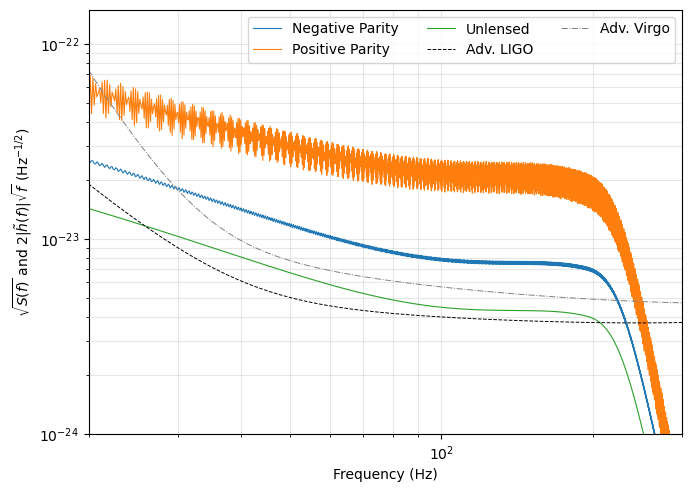

time: 497 ms (started: 2023-01-05 04:16:09 +08:00)


In [112]:
# Unlensed vs Positive Parity Lensed vs Negative Parity Lensed GWs

fig_GWs, axs_GWs = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

axs_GWs.plot(freqs_lensed_neg, (2*np.abs(lensed_sH1_neg))*(freqs_lensed_neg)**(1/2), label='Negative Parity', linewidth=0.8)
axs_GWs.plot(freqs_lensed_pos, (2*np.abs(lensed_sH1_pos))*(freqs_lensed_pos)**(1/2), label='Positive Parity', linewidth=0.8)
axs_GWs.plot(freqs, (2*np.abs(sH1))*(freqs)**(1/2), label='Unlensed', linewidth=0.8)

axs_GWs.plot(np.array(aLIGO_freq), (np.array(aLIGO_strain))**(1/2), label='Adv. LIGO', 
         linewidth=0.7, linestyle='--', color='black')
axs_GWs.plot(np.array(AdV_freq), (np.array(AdV_strain))**(1/2), label='Adv. Virgo', 
         linewidth=0.7, linestyle='-.', color='grey')

axs_GWs.set_xlim([20, 300])
axs_GWs.set_ylim([10e-25, 1.5*10e-23])
axs_GWs.set_xscale('log')
axs_GWs.set_yscale('log')
axs_GWs.minorticks_on()

#axs_GWs.set_title(r'Enhanced Microlensing on Positive and Negative Parities of SIE')
axs_GWs.set(xlabel=r'Frequency (Hz)', ylabel=r'$\sqrt{S(f)}$ and $2|\tilde{h}(f)|\sqrt{f}$ (Hz$^{-1/2}$)')
axs_GWs.legend(ncol=1, loc='upper right')

plt.grid(True, which='both', alpha=0.3)
plt.legend(ncol=3, loc='upper right')
plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/EnhanceMicrolensing', dpi=300)
plt.show()

## Fringe Analysis

/var/folders/z7/s5rym2f96s37ltj5j14bx20w0000gn/T/ipykernel_27101/2773414033.py:5: RuntimeWarning: invalid value encountered in true_divide
  ratio_pos = lensed_sH1_pos/sH1


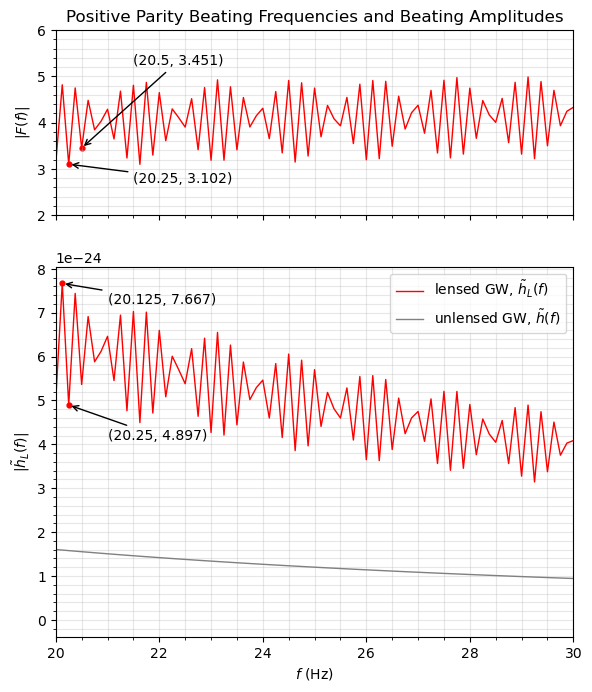

time: 796 ms (started: 2023-01-05 13:23:26 +08:00)


In [113]:
# Plot |F(omega)| vs frequency
# Estimate lens mass
# Using lensed GW from positive parity side

ratio_pos = lensed_sH1_pos/sH1
F_pos = np.abs(np.nan_to_num(ratio_pos))

fig_LensMass_pos, axs_LensMass_pos = plt.subplots(sharex=True, nrows=2, ncols=1, figsize=(6,7), gridspec_kw={'height_ratios': [1, 2]})

axs_LensMass_pos[0].plot(freqs, F_pos, color='red', linewidth=1)
axs_LensMass_pos[0].scatter([freqs[2],freqs[4]], [F_pos[2],F_pos[4]], color='red', marker='o', s=12)
axs_LensMass_pos[0].set_xlim([20,30])
axs_LensMass_pos[0].set_ylim([2, 6])
axs_LensMass_pos[0].minorticks_on()
axs_LensMass_pos[0].set(ylabel=r'$|F(f)|$')
#axs_LensMass_pos[0].set_xscale('log')
#axs_LensMass_pos[0].set_yscale('log')
axs_LensMass_pos[0].set_title(r'Positive Parity Beating Frequencies and Beating Amplitudes')
axs_LensMass_pos[0].grid(True, which='both', alpha=0.3)
axs_LensMass_pos[0].annotate('('+str(freqs[4])+', 3.451)', xy=(freqs[4], F_pos[4]), xytext=(21.5, 5.25),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
axs_LensMass_pos[0].annotate('('+str(freqs[2])+', 3.102)', xy=(freqs[2], F_pos[2]), xytext=(21.5, 2.7),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#axs_LensMass_pos[0].text(20.4, 2.85, str((freqs[2], 3.102)), color='red')

axs_LensMass_pos[1].plot(freqs, np.abs(lensed_sH1_pos), color='red', linewidth=1, label=r'lensed GW, $\tilde{h}_L(f)$')
axs_LensMass_pos[1].plot(freqs, np.abs(sH1), color='gray', linewidth=1, label=r'unlensed GW, $\tilde{h}(f)$')
axs_LensMass_pos[1].scatter(freqs[1:3], np.abs(lensed_sH1_pos)[1:3], color='red', marker='o', s=12)
axs_LensMass_pos[1].set_xlim([20,30])
#axs_LensMass_pos[1].set_ylim([5e-25, 8e-24])
#axs_LensMass_pos[1].set_xscale('log')
#axs_LensMass_pos[1].set_yscale('log')
#axs_LensMass_pos[1].set_xticklabels(rotation=90)
axs_LensMass_pos[1].minorticks_on()
axs_LensMass_pos[1].set(xlabel=r'$f$ (Hz)', ylabel=r'$|\tilde{h}_L(f)|$')
#axs_LensMass_pos[1].annotate(20.2, 77e-25, , color='red')
#axs_LensMass_pos[1].text(20.4, 48e-25, str((freqs[2], 3.102)), color='red')
axs_LensMass_pos[1].annotate('('+str(freqs[1])+', 7.667)', xy=(freqs[1], np.abs(lensed_sH1_pos)[1]), xytext=(21, 7.2e-24),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
axs_LensMass_pos[1].annotate('('+str(freqs[2])+', 4.897)', xy=(freqs[2], np.abs(lensed_sH1_pos)[2]), xytext=(21, 4.1e-24),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/LensMass_pos', dpi=300)
plt.show()

In [97]:
F_pos[4]

3.4513811516723676

time: 4.84 ms (started: 2023-01-05 02:39:00 +08:00)


In [114]:
lens_mass_pos = (1.25*10**4)*(7.667/4.897)/(20.50-20.25)
print(lens_mass_pos)
# 2 order of magnitude less than the SIE lens
# 2 orders of magnitude greater than PML


78282.62201347764
time: 670 µs (started: 2023-01-05 13:23:30 +08:00)


/var/folders/z7/s5rym2f96s37ltj5j14bx20w0000gn/T/ipykernel_27101/565321841.py:5: RuntimeWarning: invalid value encountered in true_divide
  ratio_neg = lensed_sH1_neg/sH1


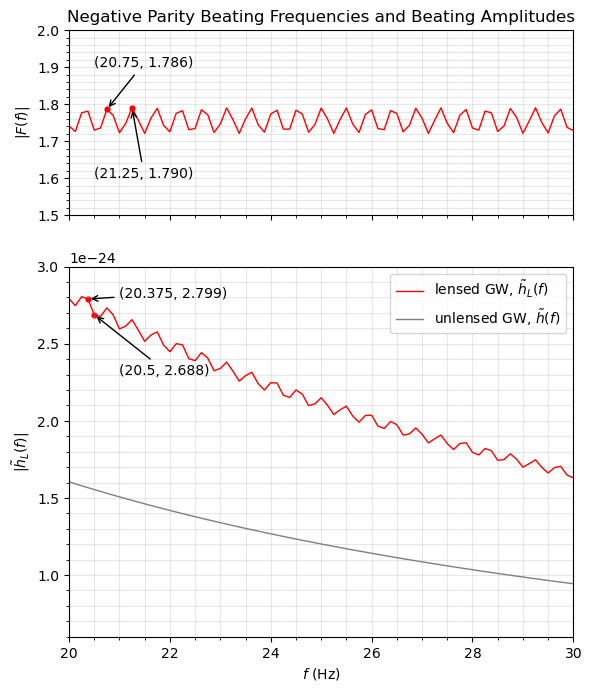

time: 534 ms (started: 2023-01-05 13:26:59 +08:00)


In [115]:
# Plot |F(omega)| vs frequency
# Estimate lens mass
# Using lensed GW from negative parity side

ratio_neg = lensed_sH1_neg/sH1
F_neg = np.abs(np.nan_to_num(ratio_neg))

fig_LensMass_neg, axs_LensMass_neg = plt.subplots(sharex=True, nrows=2, ncols=1, figsize=(6,7), gridspec_kw={'height_ratios': [1, 2]})

axs_LensMass_neg[0].plot(freqs, F_neg, color='red', linewidth=1)
axs_LensMass_neg[0].scatter([freqs[6],freqs[10]], [F_neg[6],F_neg[10]], color='red', marker='o', s=12)
axs_LensMass_neg[0].set_xlim([20,30])
axs_LensMass_neg[0].set_ylim([1.5, 2])
axs_LensMass_neg[0].minorticks_on()
axs_LensMass_neg[0].set(ylabel=r'$|F(f)|$')
#axs_LensMass_neg[0].set_xscale('log')
#axs_LensMass_neg[0].set_yscale('log')
axs_LensMass_neg[0].set_title(r'Negative Parity Beating Frequencies and Beating Amplitudes')
axs_LensMass_neg[0].grid(True, which='both', alpha=0.3)
axs_LensMass_neg[0].annotate('('+str(freqs[6])+', 1.786)', xy=(freqs[6], F_neg[6]), xytext=(20.5, 1.9),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
axs_LensMass_neg[0].annotate('('+str(freqs[10])+', 1.790)', xy=(freqs[10], F_neg[10]), xytext=(20.5, 1.6),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
#axs_LensMass_neg[0].text(20.4, 2.85, str((freqs[2], 3.102)), color='red')

axs_LensMass_neg[1].plot(freqs, np.abs(lensed_sH1_neg), color='red', linewidth=1, label=r'lensed GW, $\tilde{h}_L(f)$')
axs_LensMass_neg[1].plot(freqs, np.abs(sH1), color='gray', linewidth=1, label=r'unlensed GW, $\tilde{h}(f)$')
axs_LensMass_neg[1].scatter(freqs[3:5], np.abs(lensed_sH1_neg)[3:5], color='red', marker='o', s=12)
axs_LensMass_neg[1].set_xlim([20,30])
axs_LensMass_neg[1].set_ylim([0.6e-24, 3e-24])
#axs_LensMass_neg[1].set_xscale('log')
#axs_LensMass_neg[1].set_yscale('log')
#axs_LensMass_neg[1].set_xticklabels(rotation=90)
axs_LensMass_neg[1].minorticks_on()
axs_LensMass_neg[1].set(xlabel=r'$f$ (Hz)', ylabel=r'$|\tilde{h}_L(f)|$')
#axs_LensMass_neg[1].annotate(20.2, 77e-25, , color='red')
#axs_LensMass_neg[1].text(20.4, 48e-25, str((freqs[2], 3.102)), color='red')
axs_LensMass_neg[1].annotate('('+str(freqs[3])+', 2.799)', xy=(freqs[3], np.abs(lensed_sH1_neg)[3]), xytext=(21, 2.8e-24),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
axs_LensMass_neg[1].annotate('('+str(freqs[4])+', 2.688)', xy=(freqs[4], np.abs(lensed_sH1_neg)[4]), xytext=(21, 2.3e-24),
                            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

plt.tight_layout(pad=1, w_pad=0, h_pad=2)
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.savefig('/Users/genebelinario/Documents/dnc_research/thesis/figures/LensMass_neg', dpi=300)
plt.show()

In [116]:
lens_mass_neg = (1.25*10**4)*(2.799/2.688)/(21.25-20.75)
print(lens_mass_neg)

# 2 orders of magnitude less than SIE mass
# 2 orders of magnitude greater than PML 

26032.36607142857
time: 650 µs (started: 2023-01-05 13:27:02 +08:00)
